In [38]:
from torchsummary import summary

Lab 5 (part 4): Transfer Learning with PyTorch
Remember to enable GPU ;-)

This tutorial is inspired by a tutorial made by Sasank Chilamkurthy. You can find the original tutorial here:

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In this tutorial, you will learn how to train your network using transfer learning. You can read more about the transfer learning at cs231n notes.

Quoting these notes,

In practice, very few people train an entire Convolutional Network
from scratch (with random initialization), because it is relatively
rare to have a dataset of sufficient size. Instead, it is common to
pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
contains 1.2 million images with 1000 categories), and then use the
ConvNet either as an initialization or a fixed feature extractor for
the task of interest.

Traditionally, people have distinguished between two types of transfer learning: finetuning and feature extraction. In finetuning, we start with a pretrained model and update all of the model’s parameters for our new task, in essence retraining the whole model. In feature extraction, we start with a pretrained model and only update the final layer weights from which we derive predictions. It is called feature extraction because we use the pretrained CNN as a fixed feature-extractor, and only change the output layer. For more technical information about transfer learning see here and here.

In practise, it is often best to combine the two approaches, simply because it makes training faster. There three basic steps:

Initialize the model: First download a pre-trained CNN. Use only the pre-trained convolutional base (encoder) and replace the final layers (decoder) with your own that you initialize with random weights.

Feature extraction: Freeze the weights of the convolutional base and train only the final layers. Train only for a few iterations. The purpose is simply to get a better starting point for finetuning.

Finetuning: Unfreeze the convolutional base and train the entire network.

However, before performing these steps, we need to load the data and set up dataloaders fro both training and validation.

1. Data loaders
First, include what's needed:

In [39]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

1.1 Download data
We will use torchvision and torch.utils.data packages for loading the data.

The problem we're going to solve today is to train a model to classify ants and bees. This dataset is a very small subset of imagenet. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

First, let's download the data from here and extract it to the current directory.

In [40]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "hymenoptera_data"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://download.pytorch.org/tutorial/"
FILENAME = "hymenoptera_data.zip"

if not (DATA_PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (DATA_PATH / FILENAME).open("wb").write(content)
import zipfile
with zipfile.ZipFile((DATA_PATH / FILENAME).as_posix(), "r") as f:
    f.extractall(DATA_PATH)

In [41]:
!ls data/hymenoptera_data

train  val


1.2 Simple data loader
Let's set up a simple DataLoader based on ImageFolder and visualize some training examples.

ImageFolder is a generic data set where the images are arranged in sub-folders corresponding to classes.
DataLoader combines a dataset and a sampler, and provides an iterable over the given dataset.

In [42]:
# The transformer is used here to reshape images to 224x224 and convert to tensor
simple_transformer = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor()])

data_dir = os.path.join(str(PATH), 'train') # 'data/hymenoptera_data/train'

# ImageFolder is a generic data set where the images are arranged in sub-folders corresponding to classes
train_set = datasets.ImageFolder(data_dir,simple_transformer)

# Combines a dataset and a sampler, and provides an iterable over the given dataset.
dataloader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)

class_names = train_set.classes

Questions 1:
What does shuffle=True mean? A: Shuffle the order in which samples are loaded read why here
What dies num_workers=4 mean? A: Num_workers tells the data loader instance how many sub-processes to use for data loading.

(228, 906, 3)


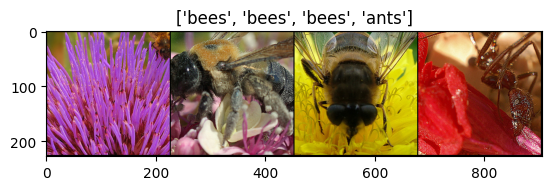

In [43]:
%matplotlib inline
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    print(inp.shape)
    if title is not None:
        plt.title(title)

# Get a random batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid of images
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

1.3 Data augmentation
We can add more variation to the training data by using data augmentation. We can do this using PyTorch's transformer.

(228, 906, 3)


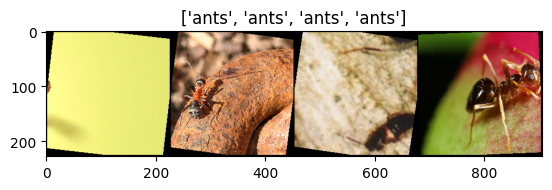

In [44]:
# Data augmentation transformer
augmentation_transformer = transforms.Compose([
        transforms.RandomResizedCrop(224), # Crop the given PIL Image to random size and aspect ratio
        transforms.RandomHorizontalFlip(0.5), # Horizontally flip the given PIL Image randomly with a given probability.
        transforms.ColorJitter(brightness=0.1), # Randomly change the brightness, contrast and saturation of an image
        transforms.RandomRotation(degrees=10), # Rotate the image by angle.
        transforms.ToTensor()])

# Same as above, expect that we are using augmentation_transformer instead of simple_transformer
train_set = datasets.ImageFolder(data_dir, augmentation_transformer)
dataloader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)
inputs, classes = next(iter(dataloader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

Questions 2:
What's the motivation for using data augmentation? A: The best form of regularization (i.e., avoiding overfitting) is adding more data! Data augmentation adds more data synthetically.
Would transforms.RandomHorizontalFlip make sense on MNIST? Why/why not? A: When performing data augmentation, the semantics (i.e., the class label) should be preserved. If you flip, say, a 2 horizontally it is no longer a valid 2.
1.4 Set up data loaders for both training and validation
Finally, we are ready to create data loaders for both training and validation.

Notice that we use dictionaries (curly brackets) here to store both train and val in the same variable.

In [45]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(brightness=0.1),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = str(PATH) # 'data/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Questions 3:
What does

transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
do, and why do you think it is needed?

A: It is used to normalize the input intensities so that they are centered around zero. The formula is output[channel] = (input[channel] - mean[channel]) / std[channel], where in our case mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. It is needed because it makes optimization easier if the inputs are centered around zero (we will learn that in a later lecture).

Visualize a few images.

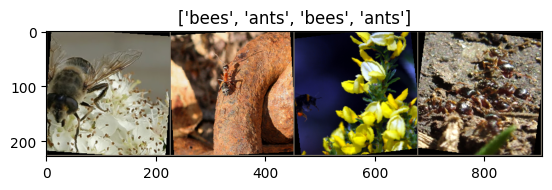

In [46]:
# Redefine imshow to handle normalization
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))

    #undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

2. Initialize the model
PyTorch has a number of pretrained models that you can choose from. See complete list here.

We will be using resnet18 here. Let's download the weights:

In [55]:
model = models.resnet18(pretrained=True)
#from torchvision import models


#vgg = models.vgg16()
summary(model.cuda(), (3, 256, 256), batch_size=-1)
#print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [ ]:
print(model.layer1) # First convolutional block
print(model.fc) # Final fully connected layer

Questions 4:
As you can see, the final layer is a Linear layer (i.e., a fully connected layer).

What is the dimensionality of the output? Why do you think it has this particular size? A: Vector of length 1000, because network was trained on ImageNet dataset, which has 1000 classes.
What dimensions should the input vector to the final layer have? A: 512 (see in_features)
2.2 Reshape final layer
Let's change the number of ouputs to 2 instead (for bees and ants).

In [ ]:
# Size of input vector to fully connected layer
num_ftrs = model.fc.in_features # 512

# Replace fully connected layer
model.fc = nn.Linear(num_ftrs, 2)

print(model.fc)

3. Set up general training function
Now, let's write a general function to train a model. Here, we will illustrate:

Scheduling the learning rate
Saving the best model (read more here)
In the following, parameter scheduler is a learning rate scheduler object from torch.optim.lr_scheduler.

In [ ]:
# Generic function to train a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Copy weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
# Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title('pred/true: {}/{}'.format(class_names[preds[j]],
                                                       class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

4. Feature extraction
Freeze the weights of the convolutional base and train only the final fully connected layer. Train only for a few iterations. The purpose is simply to get a better starting point for finetuning.

We want to set set the .requires_grad attribute of the parameters in the conovolutional base to False. By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer(s) then we want all of the other parameters to not require gradients.

You can read more about this in the documentation here.

In [ ]:
# Freeze all layers (i.e., disable training)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc)
for param in model.fc.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#4.1 Train and evaluate
#It should take around 5-10 min on CPU. On GPU though, it takes less than half a minute.

model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)


In [ ]:
visualize_model(model)

5. Fine-tune model
Finally, let's unfreeze all layers to fine-tune the model.

In [ ]:

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True


5.1 Train and evaluate
On CPU this will take more time compared to the previous scenario. This is expected as gradients need to be computed for most of the network.

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)


In [ ]:
visualize_model(model)

plt.ioff()
plt.show()

Suggestions for optional tasks
This one is related to Lab 4 part 1. For classification problems, we use cross entropy loss, also known as negative log likelihood loss. This penalizes incorrect confident predictions, and correct unconfident predictions. Can you implemnt a simple example like in Lab 4 part 1, but for logistic regression? You need to change both the model (recall the output in logistic regression is a sigmoid) and the loss function (cross entropy).

Try re-running the above tutorial with another data set (see list here) or a different CNN architecture (get inspiration here).

Object detection finetuning tutorial (use this notebook if you are working in Google Colab).